In [40]:
import numpy as np
import pickle as pkl
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import os

In [41]:
dataset = 'evaluation'
angle = 0
algo = 'pointnetvlad'
exp_dir = 'pretrained'

embeddings_file_name = f'/scratch/gurkirat.singh/training_logs/{algo}/{exp_dir}/results/embeddings_{dataset}'
database_file = embeddings_file_name+'_database.pkl'
query_file = embeddings_file_name + '_query.pkl'


os.system(f'mkdir -p analysed/{algo}/{exp_dir}')

0

In [42]:
with open(database_file, 'rb') as f:
    database = pkl.load(f)

with open(query_file, 'rb') as f:
    queries = pkl.load(f)

In [43]:
queries

{'embeddings': array([[ 3.45040262e-02, -9.63505730e-03, -3.03035136e-02, ...,
         -2.90082041e-02,  5.98085374e-02, -2.38517988e-02],
        [-9.95763764e-02, -5.29691316e-02,  1.69236407e-01, ...,
          6.22800086e-03,  2.04187701e-03, -4.12737997e-03],
        [ 6.72656903e-03,  1.39960805e-02,  8.09129514e-03, ...,
          2.02657953e-02,  9.09008924e-03,  6.74623400e-02],
        ...,
        [ 4.86480519e-02,  8.85394402e-03,  5.72866667e-03, ...,
          1.11908279e-01,  3.62017117e-02,  3.38460505e-02],
        [ 6.14805371e-02,  1.21496771e-04,  4.04521786e-02, ...,
          2.97638439e-02,  4.54020314e-02, -4.53128107e-02],
        [ 1.67132840e-02,  2.30110344e-02,  4.57773581e-02, ...,
         -1.52405715e-02,  2.84141824e-02,  8.88057053e-04]], dtype=float32),
 'positions': array([[5735747.671261,  619998.342553,       0.      ],
        [5735728.447007,  620003.548671,       0.      ],
        [5735709.234639,  620007.466377,       0.      ],
        ...,


In [44]:
def prs(queries, database, positive_range=4):
    real_loop = []
    detected_loop = []
    for i in tqdm_notebook(range(len(queries['embeddings']))):
        for j in range(len(database['embeddings'])):
            pi = queries['positions'][i]
            pj = database['positions'][j]
            ei = queries['embeddings'][i]
            ej = database['embeddings'][j]
            
            distance = np.linalg.norm(pi - pj)
            if distance <= positive_range:
                real_loop.append(1)
            else:
                real_loop.append(0)
            detected_loop.append(-np.linalg.norm(ei - ej))
            
    display = PrecisionRecallDisplay.from_predictions(real_loop, detected_loop, name=" ")
    _ = display.ax_.set_title("recision-Recall curve")
    plt.show()
    return precision_recall_curve(real_loop, detected_loop)

  0%|          | 0/882 [00:00<?, ?it/s]

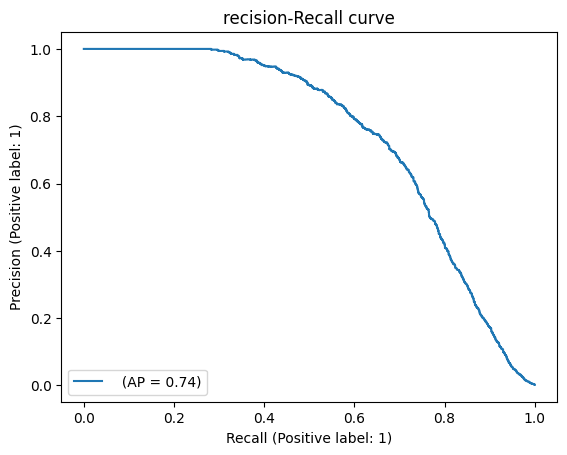

In [45]:
p, r, t = prs(queries, database, 4)
# plt.plot(r,p)

In [46]:
f_score = 2 * p * r / (p + r)
print('max f score: ', f_score.max())
f_score.argmax()

max f score:  0.6968903436988544


1461970

In [47]:
p[f_score.argmax()]

0.7454481792717087

In [48]:
p.mean()

0.011027328355572663

In [49]:
def recall_n(queries, database, positive_range=4, max_n=30):
    max_n = max(int(len(database['positions']) / 100), max_n)
    recalls = np.zeros((max_n,))
    cnt = 0
    database_poses_tree = KDTree(database['positions'])
    embeddings_tree = KDTree(database['embeddings'])
    for i in tqdm_notebook(range(100,len(queries['embeddings']))):
        # print(i)
        pi = queries['positions'][i]
        ei = queries['embeddings'][i]
        actual_indices = database_poses_tree.query_radius(pi.reshape(1,-1), r=positive_range)
        if len(actual_indices[0]) <= 0:
            continue
        cnt +=1
        _, indices = embeddings_tree.query(ei.reshape(1,-1), k=min(max_n, i-1))
        none=True
        for rank, index in enumerate(indices[0]):
            pose_distance = np.linalg.norm(pi - database['positions'][index])
            # print(pose_distance)
            if pose_distance <= positive_range:
                # print(i, rank)
                none=False
                recalls[rank:] += 1
                break
                
    recalls /= cnt
    
    return recalls

In [50]:
recalls = recall_n(queries, database, max_n=200)

  0%|          | 0/782 [00:00<?, ?it/s]

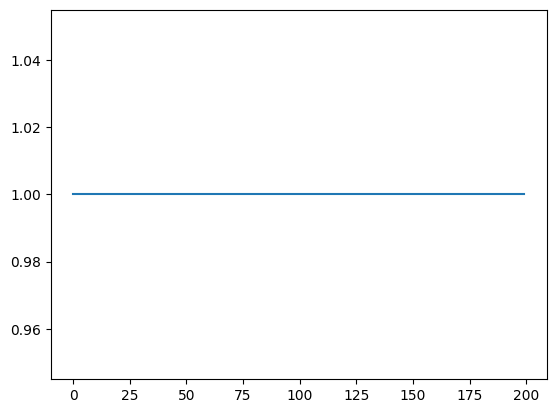

In [51]:
plt.plot(recalls)

In [52]:
# recalls[int(0.01*len(results['embeddings']))]

In [53]:
recalls[0]

1.0

In [54]:
saved_data = {
    'pr_curve': { 'p': p,'r':r,'t':t},
    'recall@n': recalls
}

In [55]:
with open(f'analysed/{algo}/{exp_dir}/analysed_{dataset}_angle_{angle}.pkl','wb') as f:
    pkl.dump(saved_data, f)

In [56]:
def protocol1(embeddings, positions, positive_range=4):
    real_loop = []
    detected_loop = []
    for i in tqdm_notebook(range(100, embeddings.shape[0])):
        poses_tree = KDTree(positions[:i])
        embeddings_tree = KDTree(embeddings[:i])
        
        actual_indices = poses_tree.query_radius(positions[i].reshape(1,-1), r=positive_range)
        if len(actual_indices[0]) <= 0:
            real_loop.append(0)
        else:
            real_loop.append(1)
        
        embeddings_indices = embeddings_tree.query(embeddings[i].reshape(1,-1),k=1)
        # print(embeddings_indices)
        candidate_index = embeddings_indices[1][0,0]
        # print(candidate_index)
        detected_loop.append(-np.linalg.norm(embeddings[i] - embeddings[candidate_index]))
        
    display = PrecisionRecallDisplay.from_predictions(real_loop, detected_loop, name=" ")
    _ = display.ax_.set_title("Precision-Recall curve")
    plt.show()
    return precision_recall_curve(real_loop, detected_loop)        
        
        


In [57]:
# protocol1(results['embeddings'], results['positions'])